<a href="https://colab.research.google.com/github/g110056012/RL-DQN/blob/main/DQN_Acrobat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

安裝

In [1]:
!apt-get install  -y xvfb

!pip install  gym==0.21 gym[box2d] pytorch-lightning==1.6.0 pyvirtualdisplay
# !pip install  https://github.com/PyTorchLightning/pytorch-lightning/archive/refs/heads/release/1.5.x.zip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  xvfb
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 784 kB of archives.
After this operation, 2,271 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.10 [784 kB]
Fetched 784 kB in 1s (1,141 kB/s)
Selecting previously unselected package xvfb.
(Reading database ... 155632 files and directories currently installed.)
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.10_amd64.deb ...
Unpacking xvfb (2:1.19.6-1ubuntu4.10) ...
Setting up xvfb (2:1.19.6-1ubuntu4.10) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheel

Setup virtual display

In [2]:
from pyvirtualdisplay import Display
Display(visible=False, size=(1400, 900)).start()

In [3]:
import copy
import gym
import torch
import random

import numpy as np
import torch.nn.functional as F

from collections import deque, namedtuple
from IPython.display import HTML
from base64 import b64encode

from torch import Tensor, nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import IterableDataset
from torch.optim import AdamW

from pytorch_lightning import LightningModule,Trainer

from gym.wrappers import RecordVideo, RecordEpisodeStatistics, TimeLimit

from pytorch_lightning.callbacks import EarlyStopping




device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
num_gpus = torch.cuda.device_count()

In [4]:
def display_video(episode=0):
  video_file = open(f'/content/videos/rl-video-episode-{episode}.mp4', "r+b").read()
  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return HTML(f"<video width=600 controls><source src='{video_url}'></video>")

Create the Deep Q-Network

In [5]:
class DQN(nn.Module):

  def __init__(self,hidden_size, obs_size, n_actions):
      super().__init__()
      self.net=nn.Sequential(
        nn.Linear(obs_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, n_actions)
      )
  
  def forward(self,x):
    return self.net(x.float())


  

Create the policy

In [6]:
def epsilon_greedy(state, env, net, epsilon=0.1):
  if np.random.random() < epsilon:
    action = env.action_space.sample()
  else: 
   state= torch.tensor([state]).to(device) 
   q_values = net(state)  
   _, action =torch.max(q_values, dim=1)
   action = int(action.item()) 
  return action  

Create the replay buffer

In [7]:
class ReplayBuffer:

  def __init__(self, capacity):
    self.buffer= deque(maxlen=capacity)
  
  def __len__(self):
    return len(self.buffer)

  def append(self, experience):
    self.buffer.append(experience) 

  def sample(self,batch_size):
    return random.sample(self.buffer,batch_size) 

In [8]:
class RLDataset(IterableDataset):

  def __init__(self, buffer, sample_size=200):
     self.buffer = buffer
     self.sample_size = sample_size
    
  def __iter__(self):
    for experience in self.buffer.sample(self.sample_size):
      yield experience

Create the environment

In [9]:
#(初始環境互動)
import gym
env = gym.make('Acrobot-v1')
# 初始化环境
initial_state = env.reset()
print(initial_state)
# 随机选择一个与环境交互
random_action = env.action_space.sample()
print(random_action)
observation, reward, done, info = env.step(random_action)
print(observation, reward)
#使用隨機策略控制
import gym
env = gym.make('Acrobot-v1')
# 初始化环境
initial_state = env.reset()
print(initial_state)
# 随机选择一个与环境交互
random_action = env.action_space.sample()
print(random_action)
observation, reward, done, info = env.step(random_action)
print(observation, reward)

[ 0.9998505   0.0172911   0.9999739  -0.00722856 -0.08085009  0.01678382]
2
[ 0.9999064  -0.01368199  0.9994843   0.03211194 -0.22116747  0.36467725] -1.0
[ 0.996579    0.08264568  0.999502   -0.03155478  0.07271055 -0.05925883]
0
[ 0.9950786   0.09908871  0.99782467 -0.06592379  0.08791445 -0.2762006 ] -1.0


In [10]:
def create_environment(name):
  env=gym.make(name)
  env=TimeLimit(env, max_episode_steps=400)
  record_interval=100
  env=RecordVideo(env, video_folder='./videos',episode_trigger=lambda x: x% record_interval==0)
  env=RecordEpisodeStatistics(env)
  return env

action_space_n= 3


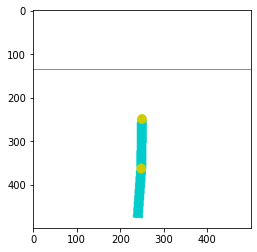

In [11]:
env=create_environment('Acrobot-v1')
env.reset()
#testing
env.observation_space.sample()
env.action_space.sample()
print("action_space_n=",env.action_space.n)

import matplotlib.pyplot as plt
plt.imshow(env.render(mode='rgb_array'))

Create the test/sampling function

In [12]:
purge=1
if purge:
  !rm -r /content/lightning_logs/
  !rm -r /content/videos/

rm: cannot remove '/content/lightning_logs/': No such file or directory


In [13]:
env2=create_environment('Acrobot-v1')
epochs=2
for episode in range(epochs):
  env2.reset()
  print('*',end="")
  done = False
  while not done:
    action=env2.action_space.sample()
    _,_,done,_, =env2.step(action)

**

In [14]:
display_video(episode=0)

Create the Deep Q-Learning algorithm

In [15]:
class DeepQLearning(LightningModule):

  #initialize
  def __init__(self, env_name, policy=epsilon_greedy, capacity=100_000, batch_size=256,lr=1e-3, 
          hidden_size=128,gamma=0.99,loss_fn=F.smooth_l1_loss, optim=AdamW, 
          eps_start=1.0,eps_end=0.15,eps_last_episode=100,samples_per_epoch=10_000,sync_rate=10):
    
    super().__init__()
    self.env=create_environment(env_name)

    obs_size= self.env.observation_space.shape[0]
    n_actions=self.env.action_space.n

    self.q_net=DQN(hidden_size,obs_size,n_actions)

    self.target_q_net= copy.deepcopy(self.q_net)

    self.policy =policy
    self.buffer=ReplayBuffer(capacity=capacity)
    self.save_hyperparameters()

    while len(self.buffer)<self.hparams.samples_per_epoch:
      print(f"{len(self.buffer)} samples in expereience buffer. Filling ...")
      self.play_episode(epsilon=self.hparams.eps_start)

  @torch.no_grad()
  def play_episode(self, policy=None, epsilon=0.):
    state= self.env.reset()
    done=False
      
    while not done:
      if policy:
        action=policy(state, self.env, self.q_net,epsilon=epsilon)
      else:
        action=self.env.action_space.sample()
      
      next_state, reward, done, info=self.env.step(action)
      exp = (state, action, reward,done,next_state)
      self.buffer.append(exp)
      state=next_state

  #Forward path
  def forward(self, x):
    return self.q_net(x)

  #Config optimumizerF
  def configure_optimizers(self):
    q_net_optimizer=self.hparams.optim(self.q_net.parameters(),lr=self.hparams.lr)
    return [q_net_optimizer]

  #prepare training state using data loader
  def train_dataloader(self):
    dataset=RLDataset(self.buffer, self.hparams.samples_per_epoch)
    dataloader=DataLoader(dataset=dataset,batch_size=self.hparams.batch_size)
    return dataloader

  # training step
  def training_step(self,batch,batch_idx):
    states, actions,rewards,dones, next_states = batch
    actions = actions.unsqueeze(1)
    rewards = rewards.unsqueeze(1)
    dones= dones.unsqueeze(1)
    #next_states = next_states.unsqueeze(1)

    state_action_values=self.q_net(states).gather(1, actions)
    next_action_values, _ =self.target_q_net(next_states).max(dim=1,keepdim=True)
    next_action_values[dones]= 0.0

    expected_state_action_values = rewards+ self.hparams.gamma*next_action_values
    loss=self.hparams.loss_fn(state_action_values, expected_state_action_values)
    self.log('episode/Q-Error',loss)
    return loss

  #training end 
  def training_epoch_end(self, training_step_outputs):

    epsilon= max(
      self.hparams.eps_end,
      self.hparams.eps_start-self.current_epoch/self.hparams.eps_last_episode
    )
    self.play_episode(policy=self.policy, epsilon=epsilon)
    self.log('episode/Return', self.env.return_queue[-1])

    if self.current_epoch % self.hparams.sync_rate==0:
      self.target_q_net.load_state_dict(self.q_net.state_dict())

Purge logs and run the visualization tool (Tensorboard)

In [ ]:
#執行階段類型須選擇GPU否則不會有值
!rm -r /content/lightning_logs/
!rm -r /content/videos/
%load_ext tensorboard
# %reload_ext tensorboard

# %tensorboard --logdir /content/lightning_logs/ --bind_all

%tensorboard --logdir /content/lightning_logs/ --bind_all

Train the policy

In [ ]:
algo = DeepQLearning('Acrobot-v1')
trainer= Trainer(
    gpus=num_gpus,
    max_epochs=10_000,
    callbacks=[EarlyStopping(monitor='episode/Return',mode='max', patience=500)]
)
trainer.fit(algo)

0 samples in expereience buffer. Filling ...
400 samples in expereience buffer. Filling ...
800 samples in expereience buffer. Filling ...
1200 samples in expereience buffer. Filling ...
1600 samples in expereience buffer. Filling ...
2000 samples in expereience buffer. Filling ...
2400 samples in expereience buffer. Filling ...
2800 samples in expereience buffer. Filling ...
3200 samples in expereience buffer. Filling ...
3600 samples in expereience buffer. Filling ...
4000 samples in expereience buffer. Filling ...
4400 samples in expereience buffer. Filling ...
4800 samples in expereience buffer. Filling ...
5200 samples in expereience buffer. Filling ...
5600 samples in expereience buffer. Filling ...
6000 samples in expereience buffer. Filling ...
6400 samples in expereience buffer. Filling ...
6800 samples in expereience buffer. Filling ...
7200 samples in expereience buffer. Filling ...
7600 samples in expereience buffer. Filling ...
8000 samples in expereience buffer. Filling .

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /content/lightning_logs


9600 samples in expereience buffer. Filling ...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type | Params
--------------------------------------
0 | q_net        | DQN  | 17.8 K
1 | target_q_net | DQN  | 17.8 K
--------------------------------------
35.6 K    Trainable params
0         Non-trainable params
35.6 K    Total params
0.142     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (_ResultMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please conside